<a href="https://colab.research.google.com/github/mariam1277/mariam1277/blob/main/99brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install requirements
!pip install kaggle imutils

# Setup Kaggle
from google.colab import files
files.upload()  # Upload your kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip dataset
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip -d dataset

# Setup directories
!mkdir -p processed/Training processed/Testing

import cv2
import numpy as np
import os
import imutils

# Simplified image processing
def process_image(img_path, size=256):
    img = cv2.imread(img_path)
    if img is None: return None

    # Crop tumor region
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    cnts = imutils.grab_contours(cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE))
    if not cnts: return cv2.resize(img, (size, size))

    c = max(cnts, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)
    cropped = img[y:y+h, x:x+w]

    # Convert to grayscale and resize
    processed = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    processed = cv2.resize(processed, (size, size))
    return processed

# Process all images
for split in ['Training', 'Testing']:
    for class_name in os.listdir(f'dataset/{split}'):
        os.makedirs(f'processed/{split}/{class_name}', exist_ok=True)

        for img_name in os.listdir(f'dataset/{split}/{class_name}'):
            src_path = f'dataset/{split}/{class_name}/{img_name}'
            dest_path = f'processed/{split}/{class_name}/{img_name}'

            result = process_image(src_path)
            if result is not None:
                cv2.imwrite(dest_path, result)

print("Processing complete!")
!ls processed/Training/*

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
Processing complete!
processed/Training/glioma:
Tr-gl_0010.jpg	Tr-gl_0231.jpg	Tr-gl_0452.jpg	Tr-gl_0673.jpg	Tr-gl_0894.jpg	Tr-gl_1115.jpg
Tr-gl_0011.jpg	Tr-gl_0232.jpg	Tr-gl_0453.jpg	Tr-gl_0674.jpg	Tr-gl_0895.jpg	Tr-gl_1116.jpg
Tr-gl_0012.jpg	Tr-gl_0233.jpg	Tr-gl_0454.jpg	Tr-gl_0675.jpg	Tr-gl_0896.jpg	Tr-gl_1117.jpg
Tr-gl_0013.jpg	Tr-gl_0234.jpg	Tr-gl_0455.jpg	Tr-gl_0676.jpg	Tr-gl_0897.jpg	Tr-gl_1118.jpg
Tr-gl_0014.jpg	Tr-gl_0235.jpg	Tr-gl_0456.jpg	Tr-gl_0677.jpg	Tr-gl_0898.jpg	Tr-gl_1119.jpg
Tr-gl_0015.jpg	Tr-gl_0236.jpg	Tr-gl_0457.jpg	Tr-gl_0678.jpg	Tr-gl_0899.jpg	Tr-gl_1120.jpg
Tr-gl_0016.jpg	Tr-gl_0237.jpg	Tr-gl_0458.jpg	Tr-gl_0679.jpg	Tr-gl_0900.jpg	Tr-gl_1121.jpg
Tr-gl_0017.jpg	Tr-gl_0238.jpg	Tr-gl_0459.jpg	Tr-gl_0680.jpg	Tr-gl_0901.jpg	Tr-gl_1122.jpg
Tr-gl_0018.jpg	Tr-gl_0239.jpg	Tr-gl_0460.jpg	Tr-gl_0681.jpg	Tr-gl_0902.jpg	Tr-gl_1123.jpg
Tr

In [54]:
basepath="/content/dataset"
newimgpath=[]
sub_dirs = ['Training', 'Testing']
categories = ['pituitary', 'glioma', 'meningioma', 'notumor']

In [55]:
for sub_dir in sub_dirs:
    for category in categories:
        folder_path = os.path.join(basepath, sub_dir, category)
        if not os.path.exists(folder_path):
            print(f"Skipping non-existing folder: {folder_path}")
            continue


        for img in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img)
            newimgpath.append(img_path)

print(f" A total of.{len(newimgpath)} image paths were created")


Toplam 7023 görüntü yolu oluşturuldu.


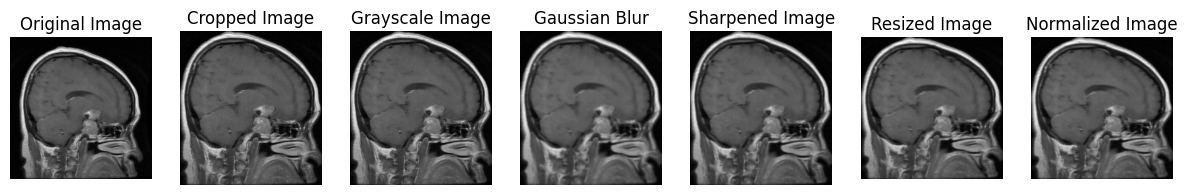

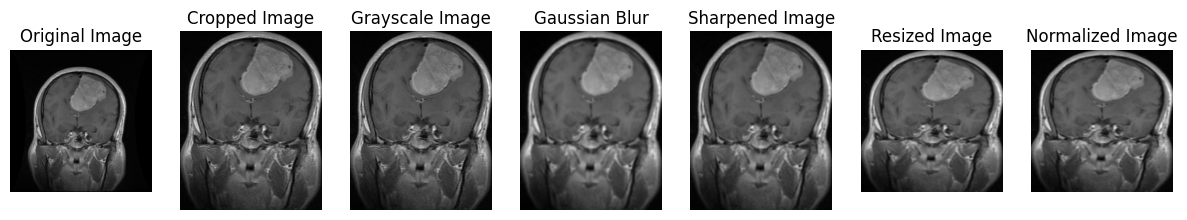

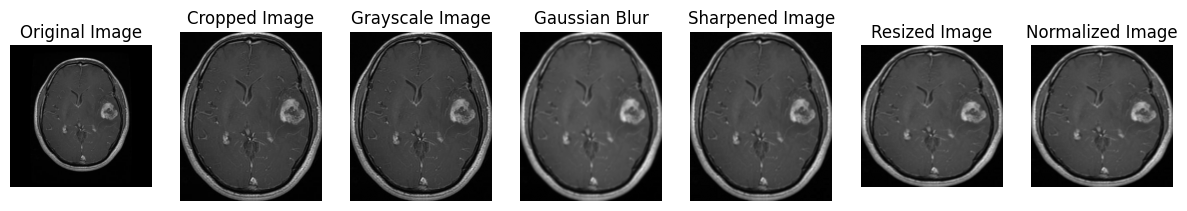

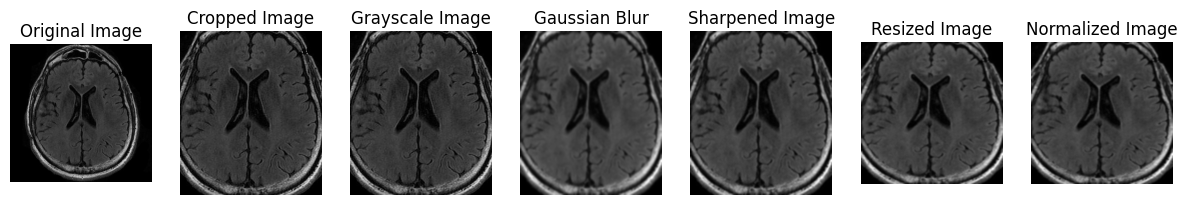

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

def crop_img(img):
    """
    Finds the extreme points in the image and crops a rectangular section between them.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Create a binary mask using thresholding
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours and select the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if not cnts:
        print("No contours found, skipping image")
        return img  # Return the original image if no contour is found

    c = max(cnts, key=cv2.contourArea)
    # Find extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    ADD_PIXELS = 0
    new_img = img[extTop[1] - ADD_PIXELS: extBot[1] + ADD_PIXELS, extLeft[0] - ADD_PIXELS: extRight[0] + ADD_PIXELS].copy()
    return new_img

def process_and_show_images(image_paths, img_size):
    """
    Process images and display each step side by side.
    """
    # Sharpening kernel
    sharpen_kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])

    # Process and display images
    for img_path in image_paths:
        try:
            # Read the image
            img = cv2.imread(img_path)

            # Check if the image is loaded correctly
            if img is None:
                print(f"Error: Unable to load image {img_path}. Skipping...")
                continue  # Skip this im
             # Crop the image
            cropped_img = crop_img(img)

            # Convert to grayscale
            gray_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)

            # Apply Gaussian Blur
            blurred_img = cv2.GaussianBlur(gray_img, (9, 9), 0)

            # Sharpen the image
            sharpened_img = cv2.filter2D(blurred_img, -1, sharpen_kernel)

            # Resize the image
            resized_img = cv2.resize(sharpened_img, (img_size, img_size))

            # Min-max normalization
            min_val = np.min(resized_img)
            max_val = np.max(resized_img)
            normalized_img = (resized_img - min_val) / (max_val - min_val)

            # Display images side by side in a single row
            plt.figure(figsize=(15, 10))

            # Original Image
            plt.subplot(1, 7, 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title("Original Image")
            plt.axis('off')
             # Cropped Image
            plt.subplot(1, 7, 2)
            plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
            plt.title("Cropped Image")
            plt.axis('off')

            # Grayscale Image
            plt.subplot(1, 7, 3)
            plt.imshow(gray_img, cmap='gray')
            plt.title("Grayscale Image")
            plt.axis('off')

            # Gaussian Blur
            plt.subplot(1, 7, 4)
            plt.imshow(blurred_img, cmap='gray')
            plt.title("Gaussian Blur")
            plt.axis('off')

            # Sharpened Image
            plt.subplot(1, 7, 5)
            plt.imshow(sharpened_img, cmap='gray')
            plt.title("Sharpened Image")
            plt.axis('off')

            # Resized Image
            plt.subplot(1, 7, 6)
            plt.imshow(resized_img, cmap='gray')
            plt.title("Resized Image")
            plt.axis('off')

            # Normalized Image
            plt.subplot(1, 7, 7)
            plt.imshow(normalized_img, cmap='gray')
            plt.title("Normalized Image")
            plt.axis('off')

            plt.show()

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Image file paths
image_paths = [
     basepath+"/Training/pituitary/Tr-pi_1435.jpg",
     basepath+"/Training/meningioma/Tr-me_0898.jpg",
     basepath+"/Training/glioma/Tr-gl_1279.jpg",
     basepath+"/Training/notumor/Tr-no_1000.jpg"
]

# Image size
IMG_SIZE = 256

# Process and display images
process_and_show_images(image_paths, IMG_SIZE)



 7023 images created.
pituitary: 1757 images
meningioma: 1645 images
glioma: 1621 images
notumor: 2000 images


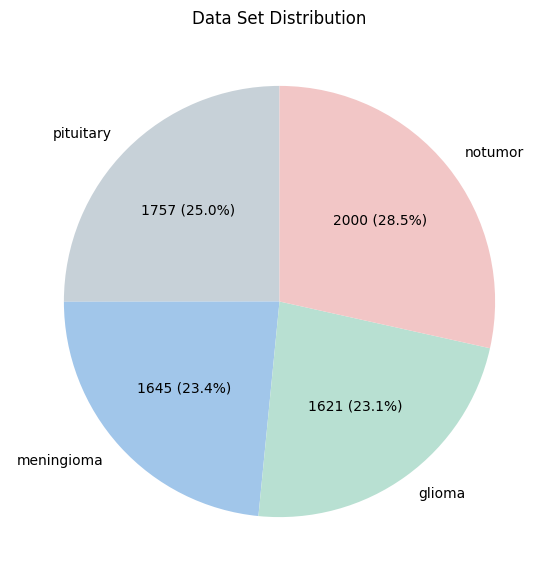

In [58]:
import os
import matplotlib.pyplot as plt

# New image path list
newimgpath = []
categories = ['pituitary', 'meningioma', 'glioma', 'notumor']
sub_dirs = ['Training', 'Testing']

category_counts = {category: 0 for category in categories}

# Collecting image paths
for sub_dir in sub_dirs:
    for category in categories:
        folder_path = os.path.join(basepath, sub_dir, category)
        if not os.path.exists(folder_path):
            print(f"Skipping non-existing folder: {folder_path}")
            continue

        for img in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img)
            newimgpath.append(img_path)

            # Incrementing the category count
            if category in category_counts:
                category_counts[category] += 1

# Total images
total_images = len(newimgpath)
print(f" {total_images} images created.")

# Calculating the percentage of category counts
categories = list(category_counts.keys())
counts = list(category_counts.values())
percentages = [(count / total_images) * 100 for count in counts]

# Print the number of images in each category
for category, count in category_counts.items():
    print(f"{category}: {count} images")

# Function for label formatting in the pie chart
def autopct_format(pct, allvalues):
    absolute = int(pct / 100. * sum(allvalues))
    return f"{absolute} ({pct:.1f}%)"

# Choosing pastel and neutral color palette
colors = ['#C7D1D8', '#A1C6EA', '#B8E0D2', '#F2C6C6']  # Pastel blue, light blue, light green, light red

# Pie chart
plt.figure(figsize=(7, 7))
plt.pie(counts, labels=categories, autopct=lambda pct: autopct_format(pct, counts), startangle=90, colors=colors)
plt.title('Data Set Distribution')
plt.show()


In [59]:
testing_dir="/content/dataset/Testing"
training_dir="/content/dataset/Training"


In [60]:
basepath

'/content/dataset'

In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation definition
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize
    rotation_range=45,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Loading and preprocessing the dataset
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    color_mode='rgb'

)
validation_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'
     ,  color_mode='rgb'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [62]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50V2  # Add this line to import ResNet50V2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import regularizers, layers
from tensorflow.keras.optimizers import Adam  # K-fold cross-validation and model training
import tensorflow as tf  # Import tensorflow


def create_deeper_mri_model(input_shape=(256, 256,3), num_classes=4):
    # Pre-trained ResNet50V2 model
    base_model = ResNet50V2(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )

    # Freeze the layers (Initially freezing)
    for layer in base_model.layers:
        layer.trainable = False

    # Feature extraction
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    # Additional layers for more depth
    x = layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.2)(x)

    # Output layer
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

    # Unfreeze the last 30 layers for further training
    for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers
        layer.trainable = True

    model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    return model
model = create_deeper_mri_model()

model.summary()



Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 64, 64, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 64, 64, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 66, 66, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 31,598,468 (120.54 MB)

 Trainable params: 22,477,188 (85.74 MB)

 Non-trainable params: 9,121,280 (34.79 MB)

In [64]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping ve ModelCheckpoint kullanımı
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Modeli eğitme
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 101s 563ms/step - accuracy: 0.9750 - loss: 2.6667 - val_accuracy: 0.9832 - val_loss: 1.9719
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 101s 566ms/step - accuracy: 0.9772 - loss: 1.8287 - val_accuracy: 0.9809 - val_loss: 1.3895
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 106s 590ms/step - accuracy: 0.9789 - loss: 1.3014 - val_accuracy: 0.9558 - val_loss: 1.0914
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 134s 548ms/step - accuracy: 0.9763 - loss: 0.9647 - val_accuracy: 0.9870 - val_loss: 0.7425
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 101s 563ms/step - accuracy: 0.9852 - loss: 0.7155 - val_accuracy: 0.9855 - val_loss: 0.5862
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 102s 567ms/step - accuracy: 0.9848 - loss: 0.5585 - val_accuracy: 0.9916 - val_loss: 0.4553
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 99s 555ms/step - accuracy: 0.9849 - loss: 0.4579 - val_accuracy: 0.9832 - val_loss: 0.4052
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 100s 558ms/step - accuracy: 0.9872 - 

In [65]:
model.save('mrii_model.h5')

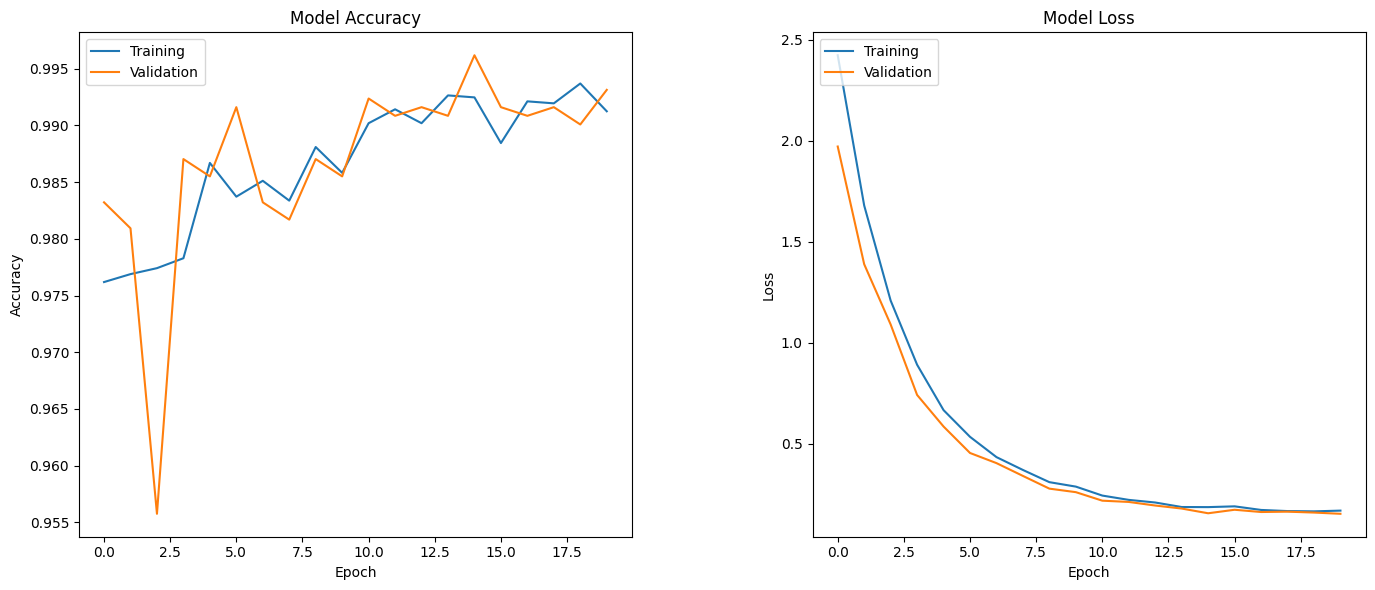

In [66]:
import matplotlib.pyplot as plt

# Set the layout of the plots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy graph
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Training', 'Validation'], loc='upper left')

# Loss graph
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Training', 'Validation'], loc='upper left')

# Increase the space between the plots
plt.subplots_adjust(wspace=100)

# Display the plots
plt.tight_layout()
plt.show()


In [67]:
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Assuming 'validation_generator' is your data generator for the validation/test set
# and 'model' is your trained model

# Obtain predictions and true labels from the validation generator
predictions = []
true_labels = []

for images, labels in validation_generator:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    predictions.extend(predicted_classes)
    true_labels.extend(labels)

    if len(predictions) >= validation_generator.samples:
        break

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Now you can calculate the metrics:
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
# Calculate regression metrics (if applicable)
mse = mean_squared_error(true_labels, predictions)
mae = mean_absolute_error(true_labels, predictions)
rmse = np.sqrt(mse)  # RMSE is the square root of MSE

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [68]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

predictions = []
true_labels = []

for images, labels in validation_generator:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    predictions.extend(predicted_classes)
    true_labels.extend(labels)

    if len(predictions) >= validation_generator.samples:
        break

predictions = np.array(predictions)
true_labels = np.array(true_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

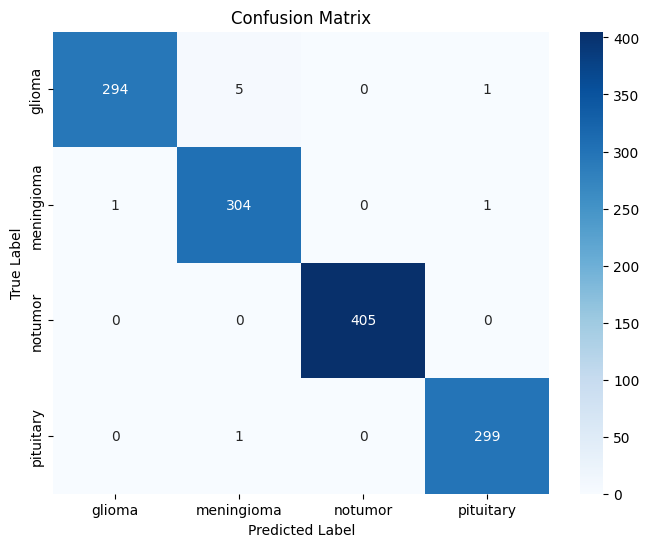

In [86]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [84]:

# Evaluate on validation data
val_results = model.evaluate(validation_generator)
print(f"Validation Loss: {val_results[0]}")
print(f"Validation Accuracy: {val_results[1] * 100:.2f}%")


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9906 - loss: 0.1590
Validation Loss: 0.1546257734298706
Validation Accuracy: 99.16%


In [3]:
# Assuming 'model' is the name of your trained model.
# You might have trained it in a previous cell.
# If not, load the model from a saved file:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import ImageDataGenerator

model = load_model('mrii_model.h5')  # Replace with your model file name

# Recreate the validation_generator (replace with your actual test data directory)
testing_dir = "/content/dataset/Testing"
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    color_mode='rgb'
)

# Continue with the evaluation
test_loss, test_acc = model.evaluate(validation_generator)  # Use validation_generator for testing data
test_acc_percentage = test_acc * 100
print(f"Test Accuracy: {test_acc_percentage:.2f}%")

Found 1311 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 248ms/step - accuracy: 0.9934 - loss: 0.1484
Test Accuracy: 99.31%


In [5]:
# Modelin genel sınıflandırma raporunu yazdır
print("\nClassification Report:\n")
print(classification_report(true_labels, predictions, target_names=validation_generator.class_indices.keys()))

# calculate TP, FP, TN, FN
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
TN = np.sum(cm) - (FP + TP + np.sum(cm, axis=1) - TP)
FN = np.sum(cm, axis=1) - TP

# print("\nTrue Positives (TP):", TP)
# print("False Positives (FP):", FP)
# print("True Negatives (TN):", TN)
# print("False Negatives (FN):", FN)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)



Classification Report:



NameError: name 'classification_report' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tahmin Sonucu: [[0.01887371 0.8341761  0.11783943 0.02911071]]
Tahmin Edilen Sınıf: meningioma


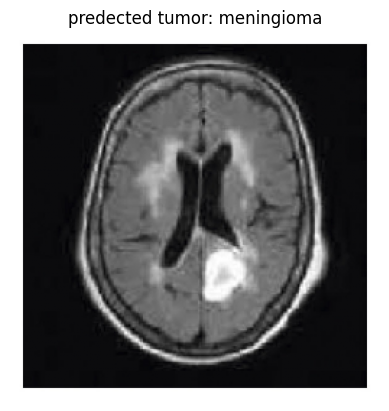

In [96]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


class_labels = ['glioma', 'meningioma', 'no tumor', 'pituitary']

def preprocess_image(img, img_size=256):

    # Check if the image was loaded correctly
    if img is None:
        print("Error: Could not load image. Please check the image path.")
        return None  # Or raise an exception

    img_resized = cv2.resize(img, (img_size, img_size))

    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    img_normalized = img_rgb / 255.0

    img_array = np.expand_dims(img_normalized, axis=0)  # (224, 224, 3) => (1, 224, 224, 3)

    return img_array

def predict_image(img_path, model, img_size=256):
    img = cv2.imread(img_path)

    # Check if the image was loaded correctly
    if img is None:
        print(f"Error: Could not load image from {img_path}. Please check the image path.")
        return None  # Or raise an exception

    processed_img = preprocess_image(img, img_size)

    # Check if preprocess_image returned None (indicating an error)
    if processed_img is None:
        return None

    prediction = model.predict(processed_img)

    predicted_class = np.argmax(prediction)  # En yüksek olasılığa sahip sınıf
    predicted_label = class_labels[predicted_class]  # Sınıf etiketi

    print("Prediction Result:", prediction)
    print("Predicted Class::", predicted_label)

    # Görüntüyü göster
    plt.imshow(processed_img[0])  # İşlenmiş görüntüyü göster
    plt.title(f"predected tumor: {predicted_label}")
    plt.axis('off')
    plt.show()

    return prediction
img_path =   '/content/Grey-scale-converted-image-a-and-RGB-image-of-brain-tumor-b.png'

prediction = predict_image(img_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Tahmin Sonucu: [[6.9386806e-05 3.4443551e-04 1.0906327e-04 9.9947709e-01]]
Tahmin Edilen Sınıf: pituitary


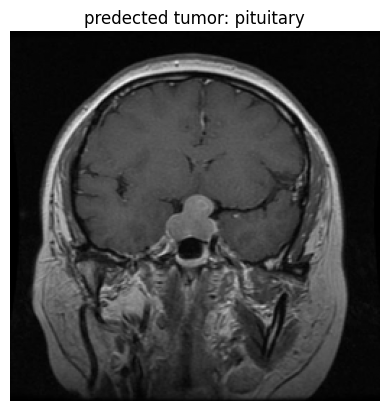

In [82]:
img_path ='/content/dataset/Testing/pituitary/Te-piTr_0001.jpg'

prediction = predict_image(img_path, model)

In [79]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

y_pred = []
y_val = []

for images, labels in validation_generator:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    y_pred.extend(predicted_classes)
    y_val.extend(labels)

    if len(y_pred) >= validation_generator.samples:
        break

report = classification_report(y_val, y_pred, output_dict=True)

print(report)


class_names = list(validation_generator.class_indices.keys())
for class_name in class_names:
    class_index = validation_generator.class_indices[class_name]  #Corrected indentation
    class_accuracy = accuracy_score(
        [1 if label == class_index else 0 for label in y_val],
        [1 if pred == class_index else 0 for pred in y_pred]
    )
    print(f"Accuracy for {class_name}: {class_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 